In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import math
import numpy as np

In [2]:
entry_df = pd.read_csv('Data_Entry_2017.csv')
print(entry_df.shape)
entry_df.head()

(112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143


## 1. Remove low quality images

### Let visualize low quality image first

In [5]:
base_dir = '/home/dattran/data/xray/'
def plot_batch(df, title, n=24):
    cols = 6
    n = min(df.shape[0], n)
    rows = math.floor(n/cols)
    plt.figure(figsize=(24, 4*rows))
    plt.suptitle(title, size=20)
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        image_file = base_dir + df.loc[i, 0]
        imshow(image_file)

def imshow(file):
    plt.imshow(Image.open(file).convert('RGB'))
    plt.xticks([])
    plt.yticks([])

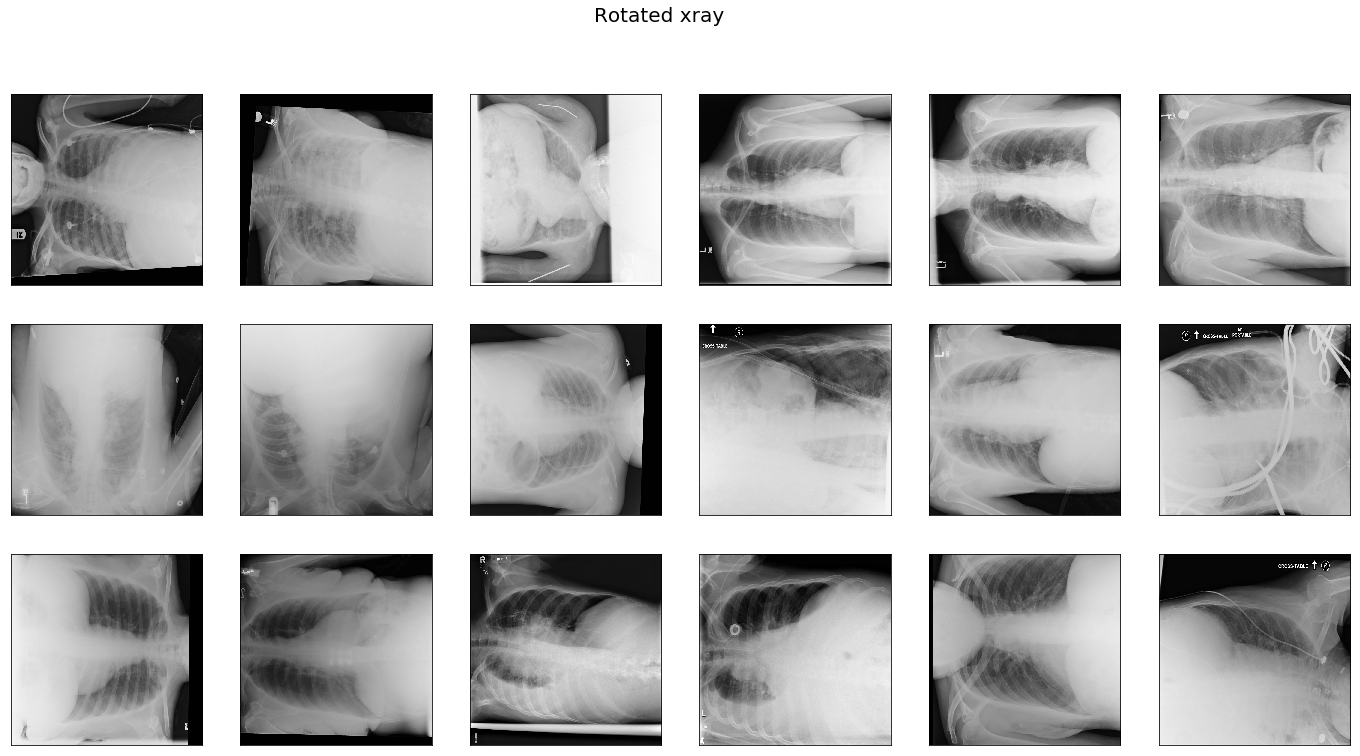

In [6]:
blacklist_rotated = pd.read_csv('blacklist_rotated_images.csv', header=None)
plot_batch(blacklist_rotated, 'Rotated xray')

56


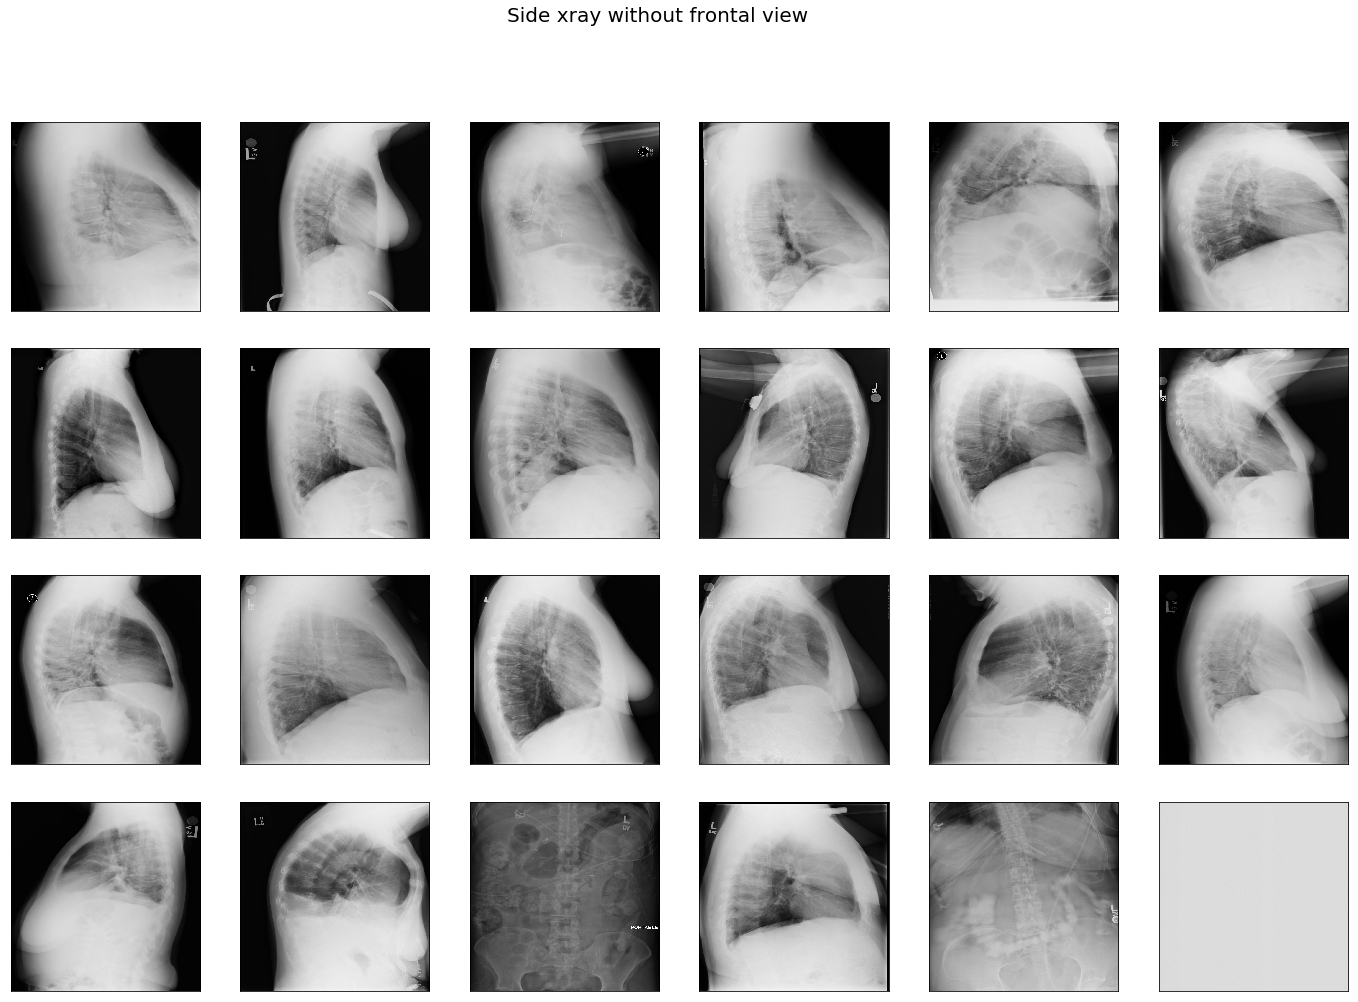

In [7]:
blacklist_nonPA = pd.read_csv('blacklist_non_PA_AP_view.csv', header=None)
print(blacklist_nonPA.shape[0])
plot_batch(blacklist_nonPA, 'Side xray without frontal view')

1094


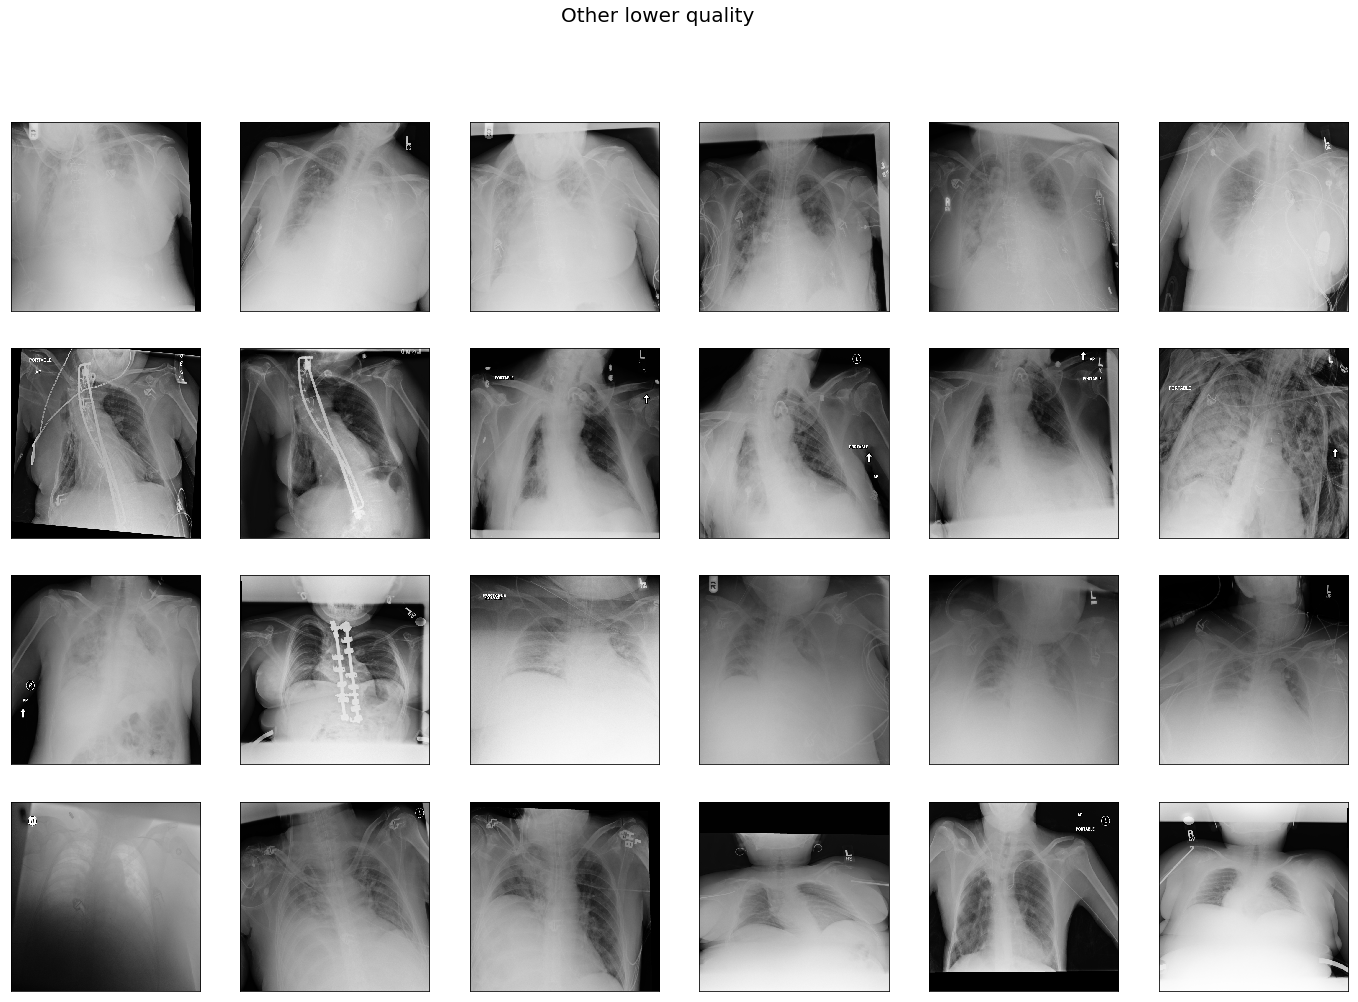

In [8]:
blacklist_other = pd.read_csv('blacklist_other_images_with_lower_quality.csv', header=None)
print(blacklist_other.shape[0])
plot_batch(blacklist_other, 'Other lower quality')


### Then remove them from dataset

In [9]:
combine = pd.concat([blacklist_other, blacklist_rotated, blacklist_nonPA])
images_to_delete = combine.values.squeeze()
print('#images to delete:', len(images_to_delete))
print('Original entry data:', entry_df.shape[0])
entry_df = entry_df[~entry_df['Image Index'].isin(images_to_delete)]
print('Entry data after delete low quality image:', entry_df.shape[0])

#images to delete: 1168
Original entry data: 112120
Entry data after delete low quality image: 110952


## 2. Remove strong label data
### The images listed in BBox_List_2017.csv were manually label by radiologist. These image will serve as baseline to evaluate the performance. Here I will delete all the patient id in the that appear in the strong label csv so that it will not contanimate the training progress

In [10]:
strong_df = pd.read_csv('BBox_List_2017.csv')
strong_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [11]:
entry_df[entry_df['Patient ID'] == 14716]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
59580,00014716_000.png,No Finding,0,14716,051Y,M,PA,2500,2048,0.168,0.168
59581,00014716_001.png,No Finding,1,14716,050Y,M,PA,2992,2991,0.143,0.143
59582,00014716_002.png,Infiltration,2,14716,051Y,M,AP,2500,2048,0.168,0.168
59583,00014716_003.png,No Finding,3,14716,051Y,M,AP,2500,2048,0.168,0.168
59584,00014716_004.png,No Finding,4,14716,051Y,M,AP,2500,2048,0.168,0.168
59585,00014716_005.png,No Finding,5,14716,051Y,M,PA,2992,2991,0.143,0.143
59586,00014716_006.png,Effusion,6,14716,053Y,M,PA,2832,2839,0.143,0.143
59587,00014716_007.png,Atelectasis|Effusion|Mass,7,14716,053Y,M,AP,3056,2544,0.139,0.139
59588,00014716_008.png,No Finding,8,14716,053Y,M,AP,3056,2544,0.139,0.139
59589,00014716_009.png,Atelectasis|Consolidation|Infiltration|Mass,9,14716,053Y,M,AP,3056,2544,0.139,0.139


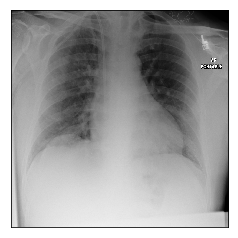

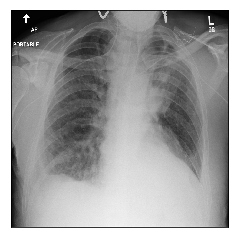

In [12]:
imshow(base_dir + '00014716_003.png')
plt.show()
imshow(base_dir + '00014716_008.png')

In [31]:
f = lambda a: print(a, 'dat')
patient_ids = [image.split('_')[0].lstrip('0') for image in strong_df['Image Index'].values]
print(len(patient_ids))


984


## 3.1 First approach:
### For image with multiple disease labels, only get the first

In [154]:
mask = ['Pneumonia' in value for value in fulldf["Finding Labels"].values]
df = fulldf[mask | (fulldf['Finding Labels'] == 'No Finding')]
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(61765, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171
1,00000005_000.png,No Finding,0,5,069Y,F,PA,2048,2500,0.168,0.168
2,00000005_001.png,No Finding,1,5,069Y,F,AP,2500,2048,0.168,0.168
3,00000005_002.png,No Finding,2,5,069Y,F,AP,2500,2048,0.168,0.168
4,00000005_003.png,No Finding,3,5,069Y,F,PA,2992,2991,0.143,0.143


In [155]:
# mask = df['Finding Labels'] == 'No Finding'
# df['Finding Labels'][mask] = 0
# df['Finding Labels'][~mask] = 1
# df.head()
df['Pneumonia'] = df['Finding Labels'].apply(lambda x: 'Pneumonia' in x)

## 3.2 Second approach: 
### For image with multiple disease labels, duplicate all the labels

## 4.Remove unused columns

In [156]:
df = df[['Image Index', 'Pneumonia', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']]
df.head()

,Image Index,Pneumonia,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000002_000.png,False,0,2,081Y,M,PA
1,00000005_000.png,False,0,5,069Y,F,PA
2,00000005_001.png,False,1,5,069Y,F,AP
3,00000005_002.png,False,2,5,069Y,F,AP
4,00000005_003.png,False,3,5,069Y,F,PA


What is PA and AP position?
https://www.med-ed.virginia.edu/courses/rad/cxr/technique3chest.html

Try this at first
``` python
import re
p = re.compile("0(.*)Y")
def convert_age(age):
    try:
        age = int(p.search(age).group(1))
    except:
        print(age)
        age = 0
    return age
```

But, 412Y, 148Y, maybe there some error while recording here, should we drop it?
```
412Y
148Y
148Y
149Y
018M
018M
020M
007M
018M
019M
019M
023M
411Y
021M
004M
413Y
412Y
001D
009M
020M
020M
013M
155Y
022M
016M
155Y
```

In [157]:
df['Age Type'] = df['Patient Age'].apply(lambda x: x[-1])
df['Age Type'].unique()

array(['Y', 'M', 'D'], dtype=object)

In [158]:
from math import ceil
df['Age'] = df['Patient Age'].apply(lambda x: x[:-1]).astype(int)
df.loc[df['Age Type']=='M', ['Age']] = df[df['Age Type'] == 'M']['Age'].apply(lambda x: ceil(x / 12.0)).astype(int)
df.loc[df['Age Type']=='D', ['Age']] = df[df['Age Type'] == 'D']['Age'].apply(lambda x: ceil(x / 365.)).astype(int)

In [159]:
df = df[['Patient ID', 'Image Index', 'Pneumonia', 'Follow-up #', 'Age', 'Patient Gender', 'View Position']]
df.rename(columns={'Patient ID': 'patient_id',
                   'Image Index': 'image', 
                   'Pneumonia': 'pneumonia', 
                   'Follow-up #': 'follow_up', 
                   'Age': 'patient_age', 
                   'Patient Gender': 'patient_gender',
                   'View Position': 'view_position'}, 
          inplace=True)
df.head()

,patient_id,image,pneumonia,follow_up,patient_age,patient_gender,view_position
0,2,00000002_000.png,False,0,81,M,PA
1,5,00000005_000.png,False,0,69,F,PA
2,5,00000005_001.png,False,1,69,F,AP
3,5,00000005_002.png,False,2,69,F,AP
4,5,00000005_003.png,False,3,69,F,PA


In [160]:
# where age > 100, turn to 100
error_df = df[df.patient_age>100]
error_df.head()

,patient_id,image,pneumonia,follow_up,patient_age,patient_gender,view_position
12418,5567,00005567_000.png,True,0,412,M,AP
28175,12238,00012238_010.png,False,10,148,M,PA
32187,13950,00013950_000.png,False,0,148,M,PA
36109,15558,00015558_000.png,False,0,149,M,PA
47170,20900,00020900_002.png,False,2,411,M,AP


In [161]:
error_ids = error_df.patient_id.values
for id_ in error_ids:
    patient_df = df[df.patient_id == id_]
    if patient_df.patient_id.count() > 1:
        # get average value of age
        average_age = int(ceil(patient_df[patient_df.patient_age < 100].patient_age.mean()))
        df.loc[(df.patient_id == id_) &  (df.patient_age > 100), ['patient_age']] = average_age

In [162]:
df[df.patient_age>100]

,patient_id,image,pneumonia,follow_up,patient_age,patient_gender,view_position
56060,26871,00026871_000.png,False,0,155,F,PA
57813,27989,00027989_000.png,False,0,155,M,PA


In [163]:
# drop remaining col
df = df[df.patient_age < 100]

In [164]:
df.describe()

,patient_id,pneumonia,follow_up,patient_age
count,61763.000000,61763,61763.000000,61763.000000
mean,13952.026229,0.02190632,6.253485,45.711170
std,8444.987794,0.1463789,12.674948,16.559033
min,2.000000,False,0.000000,1.000000
25%,6818.000000,0,0.000000,33.000000
50%,13440.000000,0,2.000000,47.000000
75%,20408.000000,0,6.000000,58.000000
max,30805.000000,True,181.000000,95.000000


In [165]:
df.dtypes

patient_id         int64
image             object
pneumonia           bool
follow_up          int64
patient_age        int64
patient_gender    object
view_position     object
dtype: object

In [167]:
# save the tidy data for further processing
df.to_csv('xray.csv', index=None)

In [4]:

strong_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [17]:
clean_data_entry = data_entry[~data_entry['Image Index'].isin(blacklist_rotated)]
clean_data_entry.shape

(112119, 11)